In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from stockapp import models as stkmd
from dataapp import models as dtamd
from dataapp import tasks as dtatks
from dataapp import libs as dtalibs
from stockapp import tasks as stktks
from stockapp import libs as stklibs
import utility as uty
import itertools as itt
import multiprocessing as mp
from django.db import connection,connections
from django.db import reset_queries
import time 
import pandas as pd
import numpy as np
import inspect
import imp
import datetime
import utility.models as utmd
import stockapp.libs as stklib
from utility import codemanager as cdmng
import json
from django.contrib.auth.models import AnonymousUser

In [27]:
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='Success').count()
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='Fail').count()
print stkmd.ComputeStatus_Stockdownload.objects.filter(Status='ToDo').count()

7098
842
0


In [28]:
stkgrpids=list(stkmd.StockGroup.objects.get(GroupName='Sector: Utilities').Symbol.all().values_list('id',flat=True))

In [15]:
Todate=pd.datetime.today().date()
Fromdate=pd.datetime(2002,1,1).date()
stk=stkmd.Stockmeta.objects.get(Symbol='UTIAvg')
df=dtalibs.GetStockData([stk.id],Fromdate,Todate,'concat')

 Time for GetStockData =  0.00325393676758


In [16]:
stk.Lastdate,stk.Startdate,stk.LastPriceUpdate

(None, None, None)

In [10]:
dtamd.Stockprice.objects.filter(Symbol_id=stk.id)

<QuerySet []>

In [13]:
stkmd.Stockmeta.objects.filter(Derived=True).update(Lastdate=None,Startdate=None,LastPriceUpdate=None)

1

# Add Index

# Building Query

In [6]:
pd.read_json('http://ec2-54-183-21-11.us-west-1.compute.amazonaws.com:8080/?symbols=TSLA,MSFT,AAPL&from=2016-01-01&to=2017-01-01')

ValueError: Mixing dicts with non-Series may lead to ambiguous ordering.

In [67]:
url='http://ec2-54-183-21-11.us-west-1.compute.amazonaws.com:8080/?symbols=TSLA,MSFT,AAPL&from=2012-01-01&to=2017-01-01'
import urllib2
response = urllib2.urlopen(url)
html = response.read()
D=json.loads(html)

In [68]:
print len(D['result'])
# pd.DataFrame(D['result'])
df=pd.DataFrame()
for d in D['result']:
    df=pd.concat([df,pd.DataFrame(d['quotes'])])
df['date']=df['date'].apply(lambda x : pd.to_datetime(x))
df

3


,adjClose,avgVolume,cci5,cci50,close,date,ema8,hasCherries,high,low,...,macdHistogram,macdSignal,open,rsi14,sma20,sma50,snapback,stddev20,symbol,volume
0,28.080000,NaN,NaN,NaN,28.080000,2012-01-03 05:00:00,NaN,None,29.500000,27.650000,...,NaN,NaN,28.940001,NaN,NaN,NaN,NaN,NaN,TSLA,928100
1,27.709999,NaN,NaN,NaN,27.709999,2012-01-04 05:00:00,NaN,None,28.670000,27.500000,...,NaN,NaN,28.209999,NaN,NaN,NaN,NaN,NaN,TSLA,630100
2,27.120001,NaN,NaN,NaN,27.120001,2012-01-05 05:00:00,NaN,None,27.930000,26.850000,...,NaN,NaN,27.760000,NaN,NaN,NaN,NaN,NaN,TSLA,1005500
3,26.910000,NaN,NaN,NaN,26.910000,2012-01-06 05:00:00,NaN,None,27.790001,26.410000,...,NaN,NaN,27.200001,NaN,NaN,NaN,NaN,NaN,TSLA,986300
4,27.250000,NaN,-73.847209,NaN,27.250000,2012-01-09 05:00:00,NaN,None,27.490000,26.120001,...,NaN,NaN,27.000000,NaN,NaN,NaN,NaN,NaN,TSLA,897000
5,27.620001,NaN,39.157526,NaN,27.620001,2012-01-10 05:00:00,NaN,None,27.760000,27.250000,...,NaN,NaN,27.440001,NaN,NaN,NaN,NaN,NaN,TSLA,671800
6,28.230000,NaN,128.226640,NaN,28.230000,2012-01-11 05:00:00,NaN,None,28.379999,27.299999,...,NaN,NaN,27.620001,NaN,NaN,NaN,NaN,NaN,TSLA,672300
7,28.250000,NaN,102.695699,NaN,28.250000,2012-01-12 05:00:00,27.646250,None,28.620001,27.809999,...,NaN,NaN,28.480000,NaN,NaN,NaN,NaN,NaN,TSLA,729300
8,22.790001,NaN,-159.180478,NaN,22.790001,2012-01-13 05:00:00,26.567084,None,28.500000,22.639999,...,NaN,NaN,28.400000,NaN,NaN,NaN,NaN,NaN,TSLA,5500400
9,26.600000,NaN,-15.782825,NaN,26.600000,2012-01-17 05:00:00,26.574398,None,27.340000,26.410000,...,NaN,NaN,26.620001,NaN,NaN,NaN,NaN,NaN,TSLA,4651600


In [73]:
print df.columns
df['hasCherries']

Index([u'adjClose', u'avgVolume', u'cci5', u'cci50', u'close', u'date',
       u'ema8', u'hasCherries', u'high', u'low', u'macd', u'macdHistogram',
       u'macdSignal', u'open', u'rsi14', u'sma20', u'sma50', u'snapback',
       u'stddev20', u'symbol', u'volume'],
      dtype='object')


0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
        ...  
1228    False
1229    False
1230    False
1231    False
1232    False
1233    False
1234    False
1235    False
1236    False
1237    False
1238    False
1239    False
1240    False
1241     True
1242    False
1243    False
1244    False
1245    False
1246    False
1247    False
1248    False
1249    False
1250    False
1251    False
1252    False
1253    False
1254    False
1255    False
1256    False
1257    False
Name: hasCherries, dtype: object

In [111]:
[pd.to_datetime(f) for f in kmeans.cluster_centers_.reshape(1,-1)[0]]

[Timestamp('2014-05-31 14:17:08.571428608'),
 Timestamp('2013-03-18 04:00:00'),
 Timestamp('2014-12-24 21:00:00'),
 Timestamp('2013-10-14 04:08:34.285714176'),
 Timestamp('2012-08-17 10:00:00'),
 Timestamp('2014-09-25 20:00:00'),
 Timestamp('2014-03-18 10:32:43.636363520'),
 Timestamp('2013-08-14 16:00:00'),
 Timestamp('2014-10-28 15:10:54.545454592'),
 Timestamp('2014-08-22 16:00:00'),
 Timestamp('2013-06-17 00:00:00'),
 Timestamp('2014-01-09 23:00:00'),
 Timestamp('2012-10-04 18:24:00'),
 Timestamp('2012-07-08 00:00:00'),
 Timestamp('2014-04-25 14:54:32.727272704'),
 Timestamp('2013-09-13 21:08:34.285714176'),
 Timestamp('2012-12-29 17:00:00'),
 Timestamp('2014-07-17 07:00:00'),
 Timestamp('2013-07-19 10:00:00'),
 Timestamp('2014-11-23 11:51:25.714285824')]

In [110]:
from sklearn.cluster import KMeans


ValueError: Length of values does not match length of index

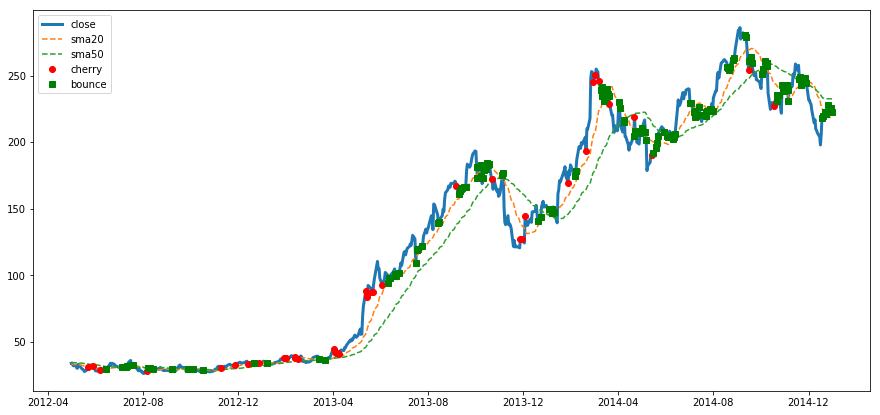

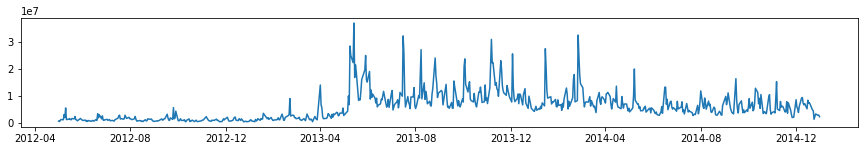

In [115]:

from sklearn.cluster import KMeans

dp=df[(df['symbol']=='TSLA') & (df['date']<pd.datetime(2015,1,1)) & (df['date']>pd.datetime(2012,5,1))]
dc=dp[dp['hasCherries']==True]
dbsma20=dp[abs(dp['close']-dp['sma20'])/dp['sma20']< 0.002*dp['stddev20']]
kmeans = KMeans(n_clusters=30, random_state=0).fit(dbsma20['date'].values.reshape(-1,1))
dateclusters=[pd.to_datetime(f) for f in kmeans.cluster_centers_.reshape(1,-1)[0]]

fig,ax=plt.subplots(1,1,figsize=(15,7))
ax.plot(dp['date'],dp['close'],linewidth=3,label='close')
ax.plot(dp['date'],dp['sma20'],'--',label='sma20')
ax.plot(dp['date'],dp['sma50'],'--',label='sma50')
# ax.plot(dp['date'],dp['sma20']+0.5*dp['stddev20'],'k--',label='+std20')
# ax.plot(dp['date'],dp['sma20']-0.5*dp['stddev20'],'k--',label='-std20')
ax.plot(dc['date'],dc['close'],'r',marker='o',linestyle='',label='cherry')
ax.plot(dbsma20['date'],dbsma20['close'],'g',marker='s',linestyle='',label='bounce')


ax.legend()
fig,ax=plt.subplots(1,1,figsize=(15,2))
ax.plot(dp['date'],dp['volume'])
plt.show()